### Implementation of Simple and Scalable Predictive Uncertainty Estimation using Deep Ensembles. [Paper](https://papers.nips.cc/paper/2017/file/9ef2ed4b7fd2c810847ffa5fa85bce38-Paper.pdf)

**Testing with mix of IN and OUT distribution**

##### notes:

1.   learning rate, optimization
2.  What about  external text set
3.  Hyperparameter Tuning





### Setting up the Environment



In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import torchvision
from torch.utils.data import Dataset
import math
import os
import time
from typing import Dict, Any, Optional
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import tqdm
from torch.optim.lr_scheduler import LambdaLR

### Load MNIST

In [3]:
class Split_MNIST_Dataset(Dataset):
    def __init__(self, mnist_dataset: Dataset, classes: [], transform=None):
        assert len(classes) > 0

        # Find the indices of examples with targets which are one of those given in classes
        split_dataset_idxs = mnist_dataset.targets == classes[0] 
        for target_class in classes[1:]:
            split_dataset_idxs = split_dataset_idxs | (mnist_dataset.targets == target_class) 

        self.data = mnist_dataset.data[split_dataset_idxs]
        self.targets = mnist_dataset.targets[split_dataset_idxs]

        self.transform = transform
    
    def __getitem__(self, index):
        img, target = self.data[index], int(self.targets[index])

        # doing this so that it is consistent with all other datasets
        # to return a PIL Image
        img = Image.fromarray(img.numpy(), mode='L')

        if self.transform is not None:
            img = self.transform(img)

        return img, target

    def __len__(self):
        return len(self.data)


In [4]:
# Load the data
class ReshapeTo784:
    def __init__(self, n):
        self.n = n

    def __call__(self, x):
        return x.view(self.n)
transform=torchvision.transforms.Compose([torchvision.transforms.ToTensor(), torchvision.transforms.Normalize((0.1307,), (0.3081,)), ReshapeTo784([784])])


In [5]:
train_data_minist =torchvision.datasets.MNIST(root='./data', train=True,
                                         transform=transform,
                                  
                                         download=True)
test_data_minist =torchvision.datasets.MNIST(root='./data', train=False,
                                         transform=transform,
                                
                                        target_transform=None, download=True)

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [6]:
# Split mnist
in_dist_train = Split_MNIST_Dataset(train_data_minist, classes=list(range(5)), transform=transform)
in_dist_test = Split_MNIST_Dataset(test_data_minist, classes=list(range(5)), transform=transform)
ood_train = Split_MNIST_Dataset(train_data_minist, classes=list(range(5, 10)), transform=transform)
ood_test = Split_MNIST_Dataset(test_data_minist, classes=list(range(5, 10)), transform=transform)

### Build training pipeline

In [7]:
 # Initialize model
 def MLP():
  model = nn.Sequential(
      nn.Linear(28*28, 200, bias=True),
      nn.BatchNorm1d(200),
      nn.ReLU(),
      nn.Linear(200, 200, bias=True),
      nn.BatchNorm1d(200),
      nn.ReLU(),
      nn.Linear(200, 200, bias=True),
      nn.BatchNorm1d(200),
      nn.ReLU(),
      nn.Linear(200, 10))
  return model

In [8]:
class SingleModelTraining:
    def __init__(self,model, training_criterion,training_set,test_set,optimizer,
                  batch_size,log_interval, test_losses, probabilities, test_accuracies,true_targets,device):
      self.training_criterion = training_criterion
      self.model = model
      self.test_dataset = test_set
      self.training_dataset = training_set
      self.optimizer = optimizer
      self.batch_size = batch_size
      self.log_interval = log_interval
      self.epoche=0
      self.num_workers= 0
      self.pin_memory=False
      # Lists for storing training/test metrics
      self.train_loss, self.test_loss = [], []
      self.train_accuracy, self.test_accuracy = [], []
       # Check that we are training on a sensible GPU
     
    
      self.device =  device
      self.step=0
       # Model
      self.model = model.to(self.device)
      self.train_loader = DataLoader(training_set,
                                        batch_size=self.batch_size,
                                     num_workers=self.num_workers,
                                      pin_memory=self.pin_memory,
                                        shuffle=True)
      self.test_loader = DataLoader(test_set,
                                        batch_size=self.batch_size,
                                    num_workers=self.num_workers,
                                      pin_memory=self.pin_memory,
                                        shuffle=False)
      if torch.cuda.is_available():
        print("Let's use", torch.cuda.device_count(), "GPUs")
        self.model = nn.DataParallel(self.model)
      self.model.to(self.device)

    def startTrainingSingleModel(self, nbr_epochs: int) -> None:
        for epoch in range( self.epoche,  nbr_epochs):
            begining_time = time.time()

            self.model.train()  # Set model in train mode
            self._train_1_epoch()
            self.test()
            
            avg_train_loss = np.mean(self.train_loss[-math.floor(len(self.train_loader) / self.log_interval):])
            print(f"Epoch {epoch}:\tTest Loss: {np.round(self.test_loss[-1], 6)};\t"
      
                  f"Test Accuracy.: {np.round(self.test_accuracy[-1], 4)}s")

    def _train_1_epoch(self):
        correct_classified_nbr = 0  # Keep track of num. correctly classified examples
        for batch_idx, (inputs, target) in enumerate(self.train_loader, 0):
            self.optimizer.zero_grad()
            inputs, target = map(lambda x: x.to(self.device, non_blocking=self.pin_memory), (inputs, target))
            
            
            outputs = self.model(inputs)
            loss = self.training_criterion(outputs, target)    
            assert torch.isnan(loss) == torch.tensor([0], dtype=torch.uint8).to(self.device)
            loss.backward() 
            self.optimizer.step()
            self.step += 1
            # log statistics
            if self.step % self.log_interval == 0:
                self.train_loss.append(loss.item())
            correct_classified_nbr += (torch.argmax(outputs, dim=1) == target).sum().cpu().item()
        self.train_accuracy.append(correct_classified_nbr / len(self.train_loader.dataset))
        self.epoche += 1
        
    def test(self):
      self.model.eval()
      test_loss = 0
      correct = 0
      with torch.no_grad():
        for  i,(data, target) in enumerate(self.test_loader,0):
          data, target = map(lambda x: x.to(self.device),
                                         (data, target))
          output = self.model(data)
        
          test_loss += self.training_criterion(output, target)
          correct += (torch.argmax(output, dim=1) == target).sum().cpu().item()
          sm = torch.nn.Softmax()
          
          probabilities.append( sm(output) )
          true_targets.append(target)
     
      test_loss = test_loss/len(self.test_loader)
      test_accuracy = correct / len(self.test_loader.dataset)
      test_losses.append(np.round(test_loss.cpu(),4))
      
      test_accuracies.append(np.round( test_accuracy, 4))
      self.test_loss.append(test_loss.cpu())
      self.test_accuracy.append(test_accuracy)
      
     

              

In [9]:
class AdversarialTrainer(SingleModelTraining):
    def __init__(self, model,
                 training_criterion,
                 train_dataset, 
                 test_dataset,
                 optimizer,
                 batch_size,log_interval, 
                 adv_example_epsilon,
                 data_range, 
                 adv_example_type, 
                 test_losses, 
                 probabilities, 
                 test_accuracies,true_targets, device) -> None:
        super().__init__(
            model, training_criterion, train_dataset,
            test_dataset, optimizer,
            batch_size,  log_interval,test_losses, probabilities, test_accuracies,true_targets,device) 
        self.data_range=data_range
        self.device=torch.device(f"cuda:{0}")
        self.adv_epsilon=adv_example_epsilon
        if adv_example_type == 'fgsm':
            self.adv_attack = fgsm_attack
        elif adv_example_type == 'rand':
            self.adv_attack = random_attack
    
    def _train_1_epoch(self):
        n_correct = 0  # Keep track of num. correctly classified examples
        for  batch_idx, (inputs, target) in enumerate(self.train_loader):
            inputs, target = map(lambda x: x.to(self.device, non_blocking=self.pin_memory), (inputs, target))
            # Compute the adversarial example
            inputs.requires_grad = True
            self.model.zero_grad()
            self.optimizer.zero_grad()

            outputs = self.model(inputs)
            loss = self.training_criterion(outputs, target)
            loss.backward()
            self.optimizer.step()
            inputs_grad = inputs.grad.data
            inputs=inputs.to(self.device)
            perturbed_inputs = self.adv_attack(inputs, (self.data_range*self.adv_epsilon).to(device), inputs_grad.to(device))
            adv_outputs = self.model(perturbed_inputs)
            adv_loss = self.training_criterion(adv_outputs, target)
            adv_loss.backward()  # Add the adversarial loss to the gradient
            self.step += 1
            # log statistics
            if self.step % self.log_interval == 0:
                self.train_loss.append(loss.item())
            n_correct += (torch.argmax(outputs, dim=1) == target).sum().cpu().item()
        self.train_accuracy.append(n_correct / len(self.train_loader.dataset))
        self.epoche += 1


def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image

    perturbed_image = image + epsilon*sign_data_grad
     # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image


def random_attack(image, epsilon, data_grad):
    # Generate a random direction with 1, -1 entries
    rand_sign = 2*(torch.bernoulli(torch.ones_like(image)*0.5) - 0.5)
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*rand_sign
      # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image
    

In [10]:
# Compute the data range
def compute_dataset_range(dataset):
    data_max = -np.ones(dataset[0][0].shape, dtype=np.float64)*np.inf
    data_min = np.ones_like(data_max)*np.inf
    for i in tqdm.tqdm(range(len(dataset))):
        x = in_dist_train[i][0].numpy()
        data_max = np.maximum(data_max, x)
        data_min = np.minimum(data_min, x)
    return data_max - data_min

### Training the different models

In [11]:
data_range=compute_dataset_range(in_dist_train)

100%|██████████| 30596/30596 [00:06<00:00, 5083.42it/s]


In [12]:



batch_size = 100
n_epochs=20


In [13]:
# Ensemble training:
test_cases=[1,5,10]
list_at_models = dict()
list_trainers = dict()
list_test_losses =dict()
list_probabilities=dict()
list_test_accuracies= dict()
list_true_targets= dict()
for case in test_cases:
  at_models = []
  trainers = []
  test_losses =[]
  probabilities=[]
  test_accuracies= []
  true_targets = []
  for i in range(case):
      model = MLP()
      optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
      criterion = torch.nn.CrossEntropyLoss()
      device=torch.device(f"cuda:{0}")
      trainer = SingleModelTraining(model, criterion, in_dist_train,test_data_minist, optimizer,batch_size,100,test_losses, probabilities, test_accuracies,true_targets,device)
      trainer.startTrainingSingleModel(n_epochs)
      
      at_models.append(model)
      trainers.append(trainer)
  list_at_models[case]=at_models
  list_trainers[case]=trainers
  list_test_losses[case] =torch.tensor(test_losses).numpy()
  list_probabilities[case]=probabilities
  list_test_accuracies[case]= test_accuracies
  list_true_targets[case]=true_targets




Let's use 1 GPUs


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch 0:	Test Loss: 5.074120044708252;	Test Accuracy.: 0.5064s
Epoch 1:	Test Loss: 5.924027919769287;	Test Accuracy.: 0.5075s
Epoch 2:	Test Loss: 6.473442077636719;	Test Accuracy.: 0.5089s
Epoch 3:	Test Loss: 5.947478771209717;	Test Accuracy.: 0.5071s
Epoch 4:	Test Loss: 6.043087959289551;	Test Accuracy.: 0.5087s
Epoch 5:	Test Loss: 6.467177867889404;	Test Accuracy.: 0.5102s
Epoch 6:	Test Loss: 6.655337810516357;	Test Accuracy.: 0.5092s
Epoch 7:	Test Loss: 7.213763236999512;	Test Accuracy.: 0.5086s
Epoch 8:	Test Loss: 7.428342819213867;	Test Accuracy.: 0.5095s
Epoch 9:	Test Loss: 7.049109935760498;	Test Accuracy.: 0.5103s
Epoch 10:	Test Loss: 6.321996212005615;	Test Accuracy.: 0.5106s
Epoch 11:	Test Loss: 6.485565185546875;	Test Accuracy.: 0.508s
Epoch 12:	Test Loss: 7.325667858123779;	Test Accuracy.: 0.51s
Epoch 13:	Test Loss: 7.649529933929443;	Test Accuracy.: 0.5101s
Epoch 14:	Test Loss: 7.0005340576171875;	Test Accuracy.: 0.5097s
Epoch 15:	Test Loss: 8.038007736206055;	Test Accurac

In [14]:
np.save('result/list_at_models.npy', list_at_models) 
np.save('result/list_trainers.npy', list_trainers) 
np.save('result/list_test_losses.npy', list_test_losses) 
np.save('result/list_probabilities.npy', list_probabilities) 
np.save('result/list_test_accuracies.npy', list_test_accuracies) 
np.save('result/list_true_targets.npy', list_true_targets) 

In [15]:
a=np.load('result/list_probabilities.npy',allow_pickle=True)[()]

In [16]:
np.save('list_at_models', list_at_models) 
np.save('list_trainers', list_trainers) 
np.save('list_test_losses', list_test_losses) 
np.save('list_probabilities', list_probabilities) 
np.save('list_test_accuracies', list_test_accuracies) 
np.save('list_true_targets', list_true_targets) 

In [17]:
# Ensemble training+Random:
test_cases=[1,5,10]
R_list_at_models = dict()
R_list_trainers = dict()
R_list_test_losses =dict()
R_list_probabilities=dict()
R_list_test_accuracies= dict()
R_true_targets=dict()
for case in test_cases:
  at_models = []
  trainers = []
  test_losses =[]
  probabilities=[]
  test_accuracies= []
  true_targets = []
  for i in range(case):
      model = MLP()
      optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
      training_criterion = torch.nn.CrossEntropyLoss()
      device=torch.device(f"cuda:{0}")
      trainer = AdversarialTrainer(model, training_criterion, in_dist_train, test_data_minist, optimizer, 
                             batch_size, 100, 0.01,
                             torch.Tensor(data_range).view([1, -1]),'rand', test_losses, probabilities, test_accuracies,true_targets,device)
      trainer.startTrainingSingleModel(n_epochs)
      
      at_models.append(model)
      trainers.append(trainer)
  R_list_at_models[case]=at_models
  R_list_trainers[case]=trainers
  R_list_test_losses[case] =torch.tensor(test_losses).numpy()
  R_list_probabilities[case]=probabilities
  R_list_test_accuracies[case]=test_accuracies
  R_true_targets[case]=true_targets

Let's use 1 GPUs


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch 0:	Test Loss: 9.648728370666504;	Test Accuracy.: 0.501s
Epoch 1:	Test Loss: 8.107142448425293;	Test Accuracy.: 0.503s
Epoch 2:	Test Loss: 10.222248077392578;	Test Accuracy.: 0.5001s
Epoch 3:	Test Loss: 10.531267166137695;	Test Accuracy.: 0.5018s
Epoch 4:	Test Loss: 8.568470001220703;	Test Accuracy.: 0.5005s
Epoch 5:	Test Loss: 10.046453475952148;	Test Accuracy.: 0.5013s
Epoch 6:	Test Loss: 9.739712715148926;	Test Accuracy.: 0.5035s
Epoch 7:	Test Loss: 9.7728271484375;	Test Accuracy.: 0.5071s
Epoch 8:	Test Loss: 10.249107360839844;	Test Accuracy.: 0.5056s
Epoch 9:	Test Loss: 10.697941780090332;	Test Accuracy.: 0.5031s
Epoch 10:	Test Loss: 11.367773056030273;	Test Accuracy.: 0.5052s
Epoch 11:	Test Loss: 11.664746284484863;	Test Accuracy.: 0.5034s
Epoch 12:	Test Loss: 10.46568489074707;	Test Accuracy.: 0.5036s
Epoch 13:	Test Loss: 12.66977596282959;	Test Accuracy.: 0.5057s
Epoch 14:	Test Loss: 12.497553825378418;	Test Accuracy.: 0.5079s
Epoch 15:	Test Loss: 12.336270332336426;	Test 

In [18]:
np.save('result/R_list_at_models.npy', R_list_at_models) 
np.save('result/R_list_trainers.npy', R_list_trainers) 
np.save('result/R_list_test_losses.npy', R_list_test_losses) 
np.save('result/R_list_probabilities.npy', R_list_probabilities) 
np.save('result/R_list_test_accuracies.npy', R_list_test_accuracies) 
np.save('result/R_true_targets.npy', R_true_targets) 

In [19]:
# Ensemble training+AT:
test_cases=[1,5,10]
AT_list_at_models = dict()
AT_list_trainers = dict()
AT_list_test_losses =dict()
AT_list_probabilities=dict()
AT_list_test_accuracies= dict()
AT_list_true_targets = dict()
for case in test_cases:
  at_models = []
  trainers = []
  test_losses =[]
  probabilities=[]
  test_accuracies= []
  true_targets=[]
  for i in range(case):
      model = MLP()
      optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
      training_criterion = torch.nn.CrossEntropyLoss()
      device=torch.device(f"cuda:{0}")
      trainer = AdversarialTrainer(model, training_criterion, in_dist_train, test_data_minist, optimizer, 
                             batch_size, 100, 0.01,
                             torch.Tensor(data_range).view([1, -1]),'fgsm', test_losses, probabilities, test_accuracies, true_targets,device)
      trainer.startTrainingSingleModel(n_epochs)
      
      at_models.append(model)
      trainers.append(trainer)
  AT_list_at_models[case]=at_models
  AT_list_trainers[case]=trainers
  AT_list_test_losses[case] =torch.tensor(test_losses).numpy()
  AT_list_probabilities[case]=probabilities
  AT_list_test_accuracies[case]= test_accuracies
  AT_list_true_targets[case]=true_targets

Let's use 1 GPUs


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch 0:	Test Loss: 10.72439956665039;	Test Accuracy.: 0.4957s
Epoch 1:	Test Loss: 10.320438385009766;	Test Accuracy.: 0.492s
Epoch 2:	Test Loss: 12.26891803741455;	Test Accuracy.: 0.5024s
Epoch 3:	Test Loss: 11.43455696105957;	Test Accuracy.: 0.4995s
Epoch 4:	Test Loss: 9.666885375976562;	Test Accuracy.: 0.4994s
Epoch 5:	Test Loss: 11.057107925415039;	Test Accuracy.: 0.5014s
Epoch 6:	Test Loss: 10.741599082946777;	Test Accuracy.: 0.5018s
Epoch 7:	Test Loss: 11.89604377746582;	Test Accuracy.: 0.5031s
Epoch 8:	Test Loss: 10.38240909576416;	Test Accuracy.: 0.4987s
Epoch 9:	Test Loss: 10.754758834838867;	Test Accuracy.: 0.5042s
Epoch 10:	Test Loss: 10.355400085449219;	Test Accuracy.: 0.5076s
Epoch 11:	Test Loss: 11.594182968139648;	Test Accuracy.: 0.5015s
Epoch 12:	Test Loss: 11.0257568359375;	Test Accuracy.: 0.5066s
Epoch 13:	Test Loss: 12.169586181640625;	Test Accuracy.: 0.5058s
Epoch 14:	Test Loss: 12.522452354431152;	Test Accuracy.: 0.5049s
Epoch 15:	Test Loss: 13.598947525024414;	Tes

In [20]:
np.save('result/AT_list_at_models.npy', AT_list_at_models) 
np.save('result/AT_list_trainers.npy', AT_list_trainers) 
np.save('result/AT_list_test_losses.npy', AT_list_test_losses) 
np.save('result/AT_list_probabilities.npy', AT_list_probabilities) 
np.save('result/AT_list_test_accuracies.npy', AT_list_test_accuracies) 
np.save('result/AT_list_true_targets.npy', AT_list_true_targets) 

### Visualization

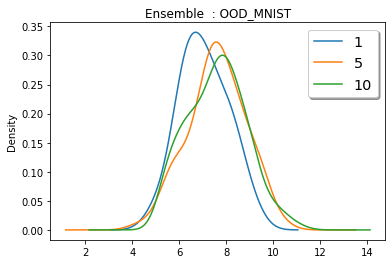

<Figure size 432x288 with 0 Axes>

In [26]:
import numpy as np
from matplotlib import pyplot as plt

import pandas as pd
fig, ax = plt.subplots()
ax.set_title("Ensemble  : OOD_MNIST")
test_cases=[1,5,10]
for case in test_cases:
  df=pd.DataFrame(list_test_losses[case], columns=[case])

  chisq_counts, chisq_bins = np.histogram(df, 5)

  #ax.plot(chisq_bins[:-1], chisq_counts,label=case,)
  df.plot.kde(ax=ax)
  #ax.plot(norm_bins[:-1], norm_counts,label='2')
  #ax.set_xlim([-0.5, 2])
  
  legend = ax.legend(loc='upper right', shadow=True, fontsize='x-large')

  # Put a nicer background color on the legend.
  legend.get_frame()

plt.show()
plt.savefig('result/Ensemble_ood.png')

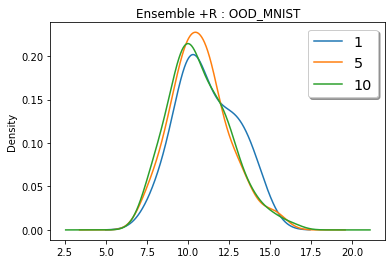

<Figure size 432x288 with 0 Axes>

In [22]:
import numpy as np
from matplotlib import pyplot as plt

import pandas as pd
fig, ax = plt.subplots()
ax.set_title("Ensemble +R : OOD_MNIST")
test_cases=[1,5,10]
for case in test_cases:
  df=pd.DataFrame(R_list_test_losses[case], columns=[case])

  chisq_counts, chisq_bins = np.histogram(df, 10)

  #ax.plot(chisq_bins[:-1], chisq_counts,label=case,scalex=True)
  #ax.plot(norm_bins[:-1], norm_counts,label='2')
  df.plot.kde(ax=ax)
  #ax.set_xlim([-0.5, 2])
  legend = ax.legend(loc='upper right', shadow=True, fontsize='x-large')

  # Put a nicer background color on the legend.
  legend.get_frame()


plt.show()
plt.savefig('result/Ensemble_R2_ood')

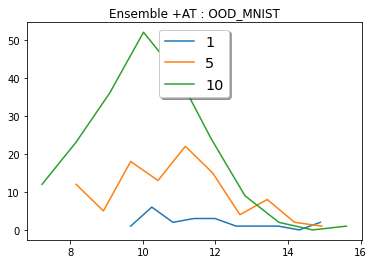

<Figure size 432x288 with 0 Axes>

In [23]:
import numpy as np
from matplotlib import pyplot as plt

import pandas as pd
fig, ax = plt.subplots()
ax.set_title("Ensemble +AT : OOD_MNIST")
test_cases=[1,5,10]
for case in test_cases:
  df=pd.DataFrame(AT_list_test_losses[case], columns=[case])

  #df.plot.kde(ax=ax)
  chisq_counts, chisq_bins = np.histogram(df, 10)

  ax.plot(chisq_bins[:-1], chisq_counts,label=case,scalex=True)
  #ax.plot(norm_bins[:-1], norm_counts,label='2')
  #ax.set_xlim([-0.5, 2])
  legend = ax.legend(loc='upper center', shadow=True, fontsize='x-large')

  # Put a nicer background color on the legend.
  legend.get_frame()

plt.show()
plt.savefig('result/Ensemble_AT2_ood')

In [24]:
while True:pass

KeyboardInterrupt: ignored

# End

###Accuracy as a function of confidence

In [38]:
a=np.load('result/list_probabilities.npy',allow_pickle=True)[()]

In [53]:
test_loader = DataLoader(test_data_minist,
                                        batch_size=batch_size,
                                    num_workers=0,
                                      pin_memory=False,
                                        shuffle=False)

In [54]:

def calc_accuracy(list_probabilities,list_true_targets):
  threshold_list=[0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
  confidences_accuracies =dict()
  for threshold in threshold_list:

    test_cases=[1,5,10]
    correct_acc=0
    for case in test_cases:
      sum_acc=0
      count=0
      for idx,prob in enumerate(list_probabilities[case]):
        confidences, predictions = torch.max(prob, 1)
        sim_vec = torch.nonzero((confidences >= threshold))
        count+=1
        accuracies = predictions[sim_vec].eq(list_true_targets[case][idx][sim_vec]).sum().item()/len(list_true_targets[case][idx])
        sum_acc+=accuracies
      correct_acc+= sum_acc / count
    confidences_accuracies[threshold]=np.round(correct_acc/len(test_cases),2)
  return confidences_accuracies
 

In [55]:
acc_df=pd.DataFrame(columns=["threshold","ensemble", "ensemble+R","ensemble+AT"])

In [57]:
threshold_list=[0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
acc_df["threshold"]=threshold_list
acc_df["ensemble"]=calc_accuracy(list_probabilities,list_true_targets).values()
acc_df["ensemble+R"]=calc_accuracy(R_list_probabilities,R_true_targets).values()

NameError: ignored

In [58]:
acc_df["ensemble+AT"]=calc_accuracy(AT_list_probabilities,AT_list_true_targets).values()


In [59]:
acc_df


,threshold,ensemble,ensemble+R,ensemble+AT
0,0.0,0.51,0.5,0.5
1,0.1,0.51,0.5,0.5
2,0.2,0.51,0.5,0.5
3,0.3,0.51,0.5,0.5
4,0.4,0.51,0.5,0.5
5,0.5,0.51,0.5,0.5
6,0.6,0.51,0.5,0.5
7,0.7,0.51,0.5,0.5
8,0.8,0.51,0.5,0.5
9,0.9,0.50,0.5,0.5


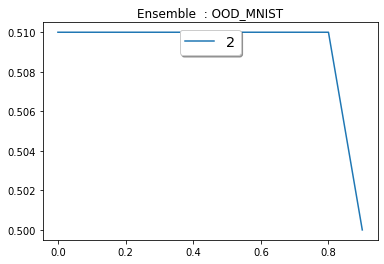

<Figure size 432x288 with 0 Axes>

In [52]:
import numpy as np
from matplotlib import pyplot as plt

import pandas as pd
fig, ax = plt.subplots()
ax.set_title("Ensemble  : OOD_MNIST")
#df.plot.kde(ax=ax)
ax.plot(acc_df["threshold"], acc_df["ensemble"],label='2')
#ax.set_xlim([-0.5, 2])
  
legend = ax.legend(loc='upper center', shadow=True, fontsize='x-large')

  # Put a nicer background color on the legend.
legend.get_frame()

plt.show()
plt.savefig('result/accuracy.png')

In [37]:
while True:pass

KeyboardInterrupt: ignored

In [84]:
list_true_targets[case][idx][1]

tensor(9, device='cuda:0')

In [83]:
predictions[1]

tensor(4, device='cuda:0')

In [69]:
len(list_probabilities[5])

2500

### Hyperparameter

### Testing on External test set

In [ ]:
torch.cuda.get_device_name(0)

'Tesla T4'

The implementation is partly inspired from this repository [here](https://github.com/KaosEngineer/PriorNetworks/tree/d6f6ffb65bbd6cfddea9726725fe6eabd501827b/prior_networks)

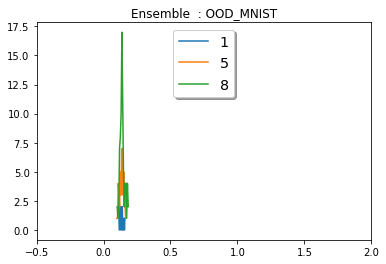

<Figure size 432x288 with 0 Axes>

In [ ]:
import numpy as np
from matplotlib import pyplot as plt

import pandas as pd
fig, ax = plt.subplots()
ax.set_title("Ensemble  : OOD_MNIST")
test_cases=[1,5,8]
for case in test_cases:
  df=pd.DataFrame(list_test_losses[case], columns=[case])

  chisq_counts, chisq_bins = np.histogram(df, 15)

  ax.plot(chisq_bins[:-1], chisq_counts,label=case,scalex=True)
  #df.plot.kde(ax=ax)
  #ax.plot(norm_bins[:-1], norm_counts,label='2')
  ax.set_xlim([-0.5, 2])
  
  legend = ax.legend(loc='upper center', shadow=True, fontsize='x-large')

  # Put a nicer background color on the legend.
  legend.get_frame()

plt.show()
plt.savefig('Ensemble_ood1')

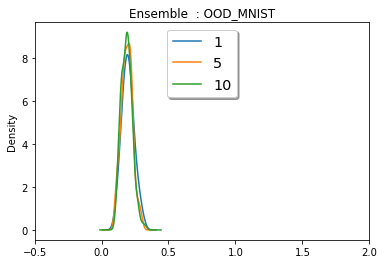

<Figure size 432x288 with 0 Axes>

In [ ]:
import numpy as np
from matplotlib import pyplot as plt

import pandas as pd
fig, ax = plt.subplots()
ax.set_title("Ensemble  : OOD_MNIST")
test_cases=[1,5,10]
for case in test_cases:
  df=pd.DataFrame(list_test_losses[case], columns=[case])

  df.plot.kde(ax=ax)
  #ax.plot(norm_bins[:-1], norm_counts,label='2')
  ax.set_xlim([-0.5, 2])
  legend = ax.legend(loc='upper center', shadow=True, fontsize='x-large')

  # Put a nicer background color on the legend.
  legend.get_frame()

plt.show()
plt.savefig('Ensemble_ood')

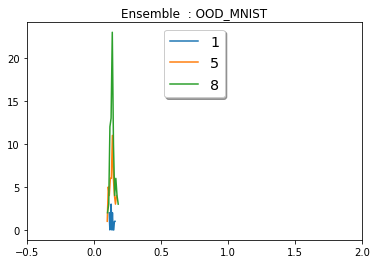

<Figure size 432x288 with 0 Axes>

In [ ]:
import numpy as np
from matplotlib import pyplot as plt

import pandas as pd
fig, ax = plt.subplots()
ax.set_title("Ensemble  : OOD_MNIST")
test_cases=[1,5,8]
for case in test_cases:
  df=pd.DataFrame(list_test_losses[case], columns=[case])

  chisq_counts, chisq_bins = np.histogram(df, 10)

  ax.plot(chisq_bins[:-1], chisq_counts,label=case)
  #df.plot.kde(ax=ax)
  #ax.plot(norm_bins[:-1], norm_counts,label='2')
  ax.set_xlim([-0.5, 2])
  
  legend = ax.legend(loc='upper center', shadow=True, fontsize='x-large')

  # Put a nicer background color on the legend.
  legend.get_frame()

plt.show()
plt.savefig('Ensemble_ood')